In [2]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import pandas as pd
import numpy as np
import roc_auc
import estimator_knn as knn
import estimator_rssibased as rssie

In [233]:
# data loader
ds = datasets.load('data/raw/0[12]_[01][123]_0[1234]*_*')

path = data/raw/0[12]_[01][123]_0[1234]*_*
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x..........................
data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
.........................x....
data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅
.....................x........
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
..............................
data/raw/01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出
..............................
data/raw/01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出
..............................
data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっす

In [308]:
# grid search implementation (under test)
def test():
    sensor_type_master = [
        ['rssi.a', 'rssi.b'],
        ['linear_accelerometer0', 'linear_accelerometer1', 'linear_accelerometer0']
    ]
    
    range_n_neighbors = np.arange(1, 5, 2)
    range_n_record = np.arange(1, 10, 10)
    range_n_train = np.arange(1, 20, 20)
    range_ms_interval = np.array([20, 40, 100])
    range_ma_window = np.arange(1, 4, 4)
    range_sensor_type = sensor_type_master
    
    mesh_data = np.meshgrid(range_n_neighbors, range_n_record, range_n_train,
                            range_ms_interval, range_ma_window, range_sensor_type)
    
    testset = []
    for n_neighbor, n_record, n_train, ms_interval, ma_window, sensor_type   in zip(mesh_data[0].ravel(), mesh_data[1].ravel(), mesh_data[2].ravel(),
               mesh_data[3].ravel(), mesh_data[4].ravel(), mesh_data[5].ravel()):
        test_case = {'n_neighbor': n_neighbor, 'n_record': n_record, 'n_train': n_train,
                    'ms_interval': ms_interval, 'ma_window': ma_window, 'sensor_type': sensor_type}
        testset.append(test_case)

    df = pd.DataFrame(testset)
    
    for key, row in df.iterrows():
        v = row.to_dict()
        print(v)
    
#    df = df[~((df.neighbor == 3) & (df['sample'] == 10))]

    return df

test()

{'ma_window': 1, 'ms_interval': 20, 'n_neighbor': 1, 'n_record': 1, 'n_train': 1, 'sensor_type': ['rssi.a', 'rssi.b']}
{'ma_window': 1, 'ms_interval': 20, 'n_neighbor': 1, 'n_record': 1, 'n_train': 1, 'sensor_type': ['linear_accelerometer0', 'linear_accelerometer1', 'linear_accelerometer0']}
{'ma_window': 1, 'ms_interval': 40, 'n_neighbor': 1, 'n_record': 1, 'n_train': 1, 'sensor_type': ['rssi.a', 'rssi.b']}
{'ma_window': 1, 'ms_interval': 40, 'n_neighbor': 1, 'n_record': 1, 'n_train': 1, 'sensor_type': ['linear_accelerometer0', 'linear_accelerometer1', 'linear_accelerometer0']}
{'ma_window': 1, 'ms_interval': 100, 'n_neighbor': 1, 'n_record': 1, 'n_train': 1, 'sensor_type': ['rssi.a', 'rssi.b']}
{'ma_window': 1, 'ms_interval': 100, 'n_neighbor': 1, 'n_record': 1, 'n_train': 1, 'sensor_type': ['linear_accelerometer0', 'linear_accelerometer1', 'linear_accelerometer0']}
{'ma_window': 1, 'ms_interval': 20, 'n_neighbor': 3, 'n_record': 1, 'n_train': 1, 'sensor_type': ['rssi.a', 'rssi.b']}


,ma_window,ms_interval,n_neighbor,n_record,n_train,sensor_type
0,1,20,1,1,1,"[rssi.a, rssi.b]"
1,1,20,1,1,1,"[linear_accelerometer0, linear_accelerometer1,..."
2,1,40,1,1,1,"[rssi.a, rssi.b]"
3,1,40,1,1,1,"[linear_accelerometer0, linear_accelerometer1,..."
4,1,100,1,1,1,"[rssi.a, rssi.b]"
5,1,100,1,1,1,"[linear_accelerometer0, linear_accelerometer1,..."
6,1,20,3,1,1,"[rssi.a, rssi.b]"
7,1,20,3,1,1,"[linear_accelerometer0, linear_accelerometer1,..."
8,1,40,3,1,1,"[rssi.a, rssi.b]"
9,1,40,3,1,1,"[linear_accelerometer0, linear_accelerometer1,..."


path = data/raw/01_0[12]_01_*
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
extracted 3 dataframes
extracted 3 dataframes
1 10
[ 0.  0.  0.]
[ 213.03142723  175.89596252  193.03871568]
[ 0.          0.          0.          0.21303143  0.17589596  0.19303872]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.  0.  1.] [ 0.33333333  1.          1.        ]


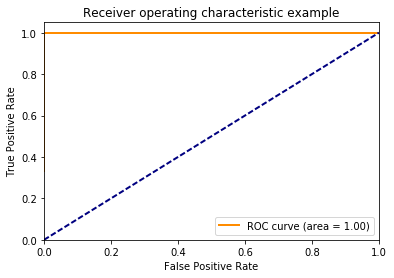

extracted 3 dataframes
extracted 3 dataframes
3 10
[ 10.76833816   8.5003724   10.76833816]
[ 216.11176133  178.37824257  195.45995085]
[ 0.01076834  0.00850037  0.01076834  0.21611176  0.17837824  0.19545995]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.          0.          0.66666667  1.        ] [ 0.33333333  1.          1.          1.        ]


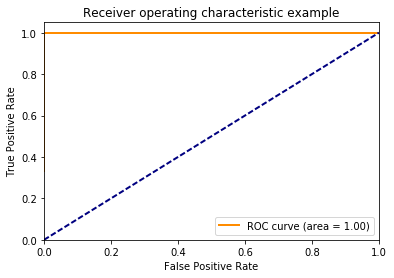

extracted 3 dataframes
extracted 3 dataframes
1 20
[ 0.  0.  0.]
[ 213.03142723  175.89596252  193.03871568]
[ 0.          0.          0.          0.21303143  0.17589596  0.19303872]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.  0.  1.] [ 0.33333333  1.          1.        ]


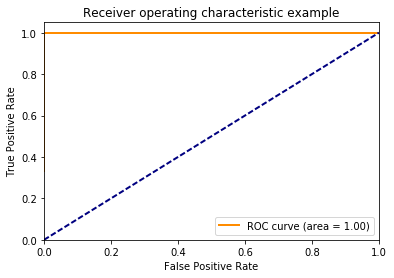

extracted 3 dataframes
extracted 3 dataframes
3 20
[ 10.76833816   8.5003724   10.76833816]
[ 216.11176133  178.37824257  195.45995085]
[ 0.01076834  0.00850037  0.01076834  0.21611176  0.17837824  0.19545995]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.          0.          0.66666667  1.        ] [ 0.33333333  1.          1.          1.        ]


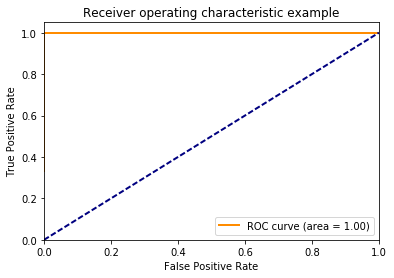

extracted 3 dataframes
extracted 3 dataframes
1 30
[ 0.  0.  0.]
[ 213.03142723  175.89596252  193.03871568]
[ 0.          0.          0.          0.21303143  0.17589596  0.19303872]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.  0.  1.] [ 0.33333333  1.          1.        ]


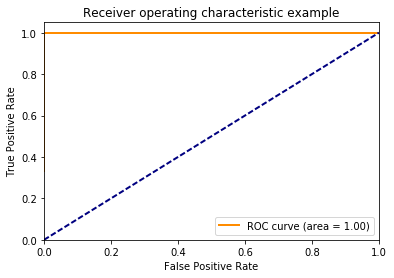

extracted 3 dataframes
extracted 3 dataframes
3 30
[ 10.76833816   8.5003724   10.76833816]
[ 216.11176133  178.37824257  195.45995085]
[ 0.01076834  0.00850037  0.01076834  0.21611176  0.17837824  0.19545995]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.          0.          0.66666667  1.        ] [ 0.33333333  1.          1.          1.        ]


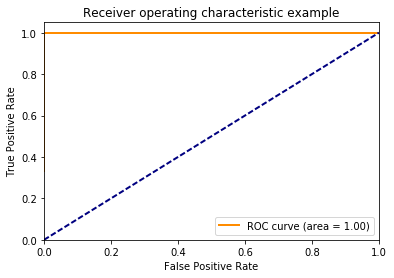

extracted 3 dataframes
extracted 3 dataframes
1 40
[ 0.  0.  0.]
[ 213.03142723  175.89596252  193.03871568]
[ 0.          0.          0.          0.21303143  0.17589596  0.19303872]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.  0.  1.] [ 0.33333333  1.          1.        ]


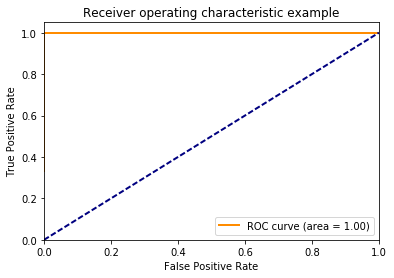

extracted 3 dataframes
extracted 3 dataframes
3 40
[ 10.76833816   8.5003724   10.76833816]
[ 216.11176133  178.37824257  195.45995085]
[ 0.01076834  0.00850037  0.01076834  0.21611176  0.17837824  0.19545995]
[0, 0, 0, 1, 1, 1]
1.0
[ 0.          0.          0.66666667  1.        ] [ 0.33333333  1.          1.          1.        ]


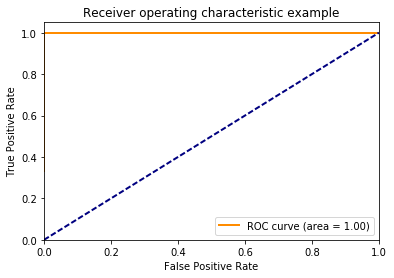

In [5]:
# mesh grid sample
import estimator_knn as knn
import roc_auc

def eval01():
    ds = datasets.load('data/raw/01_0[12]_01_*')
    column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]']]

    n_neighbors_range = np.arange(1, 5, 2)
    n_sample_range = np.arange(10, 50, 10)
    
    n_neighbors, n_samples = np.meshgrid(n_neighbors_range, n_sample_range)
    
    for n_neighbors, n_samples in np.c_[n_neighbors.ravel(), n_samples.ravel()]:
        data_n_2d, data_o_2d = datasets.get_normalized_data(ds,
                                                      title_n='01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
                                                      title_o ='01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
                                                      before=6, after=0, column=column)
        data_n = [d.ravel() for d in data_n_2d]
        data_o = [d.ravel() for d in data_o_2d]

        print(n_neighbors, n_samples)
        estimator = knn.EstimatorKNN(n_neighbors=n_neighbors)
        estimator.fit(data_n)
        value_n = estimator.decision_function(data_n)
        value_o = estimator.decision_function(data_o)
        
        print(value_n)
        print(value_o)
        print(np.hstack((value_n, value_o))/1000)
        print([0]*len(value_n) + [1]*len(value_o))

        roc_auc.get_auc(np.hstack((value_n, value_o))/1000, [0]*len(value_n) + [1]*len(value_o))
    

eval01()

--- get data ---
['01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 30 dataframes
['01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅'
 '01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅'
 '01_11_03_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅'
 '01_11_04_エネマネハウス_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅']
extracted 120 dataframes
['01_12_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出'
 '01_12_02_エネマネハウス_XperiaZ3_ズボン_裏上_異常_まっすぐ外出'
 '01_12_03_エネマネハウス_XperiaZ3_カバン_裏上_異常_まっすぐ外出'
 '01_13_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅'
 '01_13_02_エネマネハウス_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅'
 '01_13_03_エネマネハウス_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅']
extracted 180 dataframes
(120, 10)


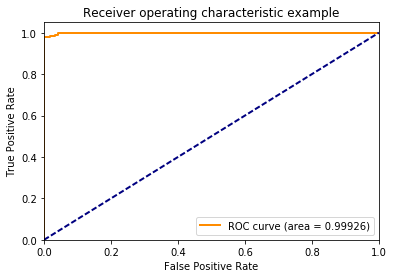

auc 0.99926


In [316]:
#  knn based algorithm test

def eval01():
    column=['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    #column = ['rssi.a', 'rssi.b', ['acceleration.x', 'acceleration.y', 'acceleration.z']]
    n_record = 3
    base = '01_11_01'
    normal = '^01_11'
    anomaly = '^01_1[23]'
    drop_interval = 5
    ma_window = 3
    n_train = 3
    normalize = True
    
    print('--- get data ---')
    dfl_b = datasets.get_data(ds, title=base, before=n_record,
                              column=column, drop_interval=drop_interval)[:n_train]
    dfl_n = datasets.get_data(ds, title=normal, before=n_record,
                              column=column, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title=anomaly, before=n_record,
                              column=column, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, column)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, column)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, column)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = knn.EstimatorKNN()
    print(np.shape(data_n))
    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o)
    print('auc %.5f'%(auc))

eval01()

--- get data ---
['01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 30 dataframes
['01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅'
 '01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅'
 '01_11_03_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅'
 '01_11_04_エネマネハウス_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅']
extracted 120 dataframes
['01_12_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出'
 '01_12_02_エネマネハウス_XperiaZ3_ズボン_裏上_異常_まっすぐ外出'
 '01_12_03_エネマネハウス_XperiaZ3_カバン_裏上_異常_まっすぐ外出'
 '01_13_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅'
 '01_13_02_エネマネハウス_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅'
 '01_13_03_エネマネハウス_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅']
extracted 180 dataframes


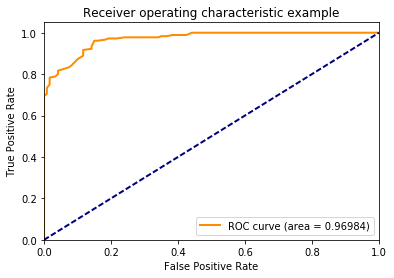

auc 0.96984


In [317]:
# rssi based method test

def eval01():
    column=['rssi.a','rssi.b']
    n_record = 3
    base = '01_11_01'
    normal = '^01_11'
    anomaly = '^01_1[23]'
    drop_interval = 5
    ma_window = 3
    n_train = 3
    normalize = False
    
    print('--- get data ---')
    dfl_b = datasets.get_data(ds, title=base, before=n_record,
                              column=column, drop_interval=drop_interval)[:n_train]
    dfl_n = datasets.get_data(ds, title=normal, before=n_record,
                              column=column, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title=anomaly, before=n_record,
                              column=column, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)

    # normalize data
    if normalize == True:
        dfl_b = datasets.normalize_by_base_data(dfl_b, dfl_b, column)
        dfl_n = datasets.normalize_by_base_data(dfl_b, dfl_n, column)
        dfl_o = datasets.normalize_by_base_data(dfl_b, dfl_o, column)
    
    # to numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b]
    data_2d_n = [df.as_matrix() for df in dfl_n]
    data_2d_o = [df.as_matrix() for df in dfl_o]

    # to list of numpy.array
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = rssie.EstimatorRssiBased()
    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o)
    print('auc %.5f'%(auc))

eval01()